<img src="./logos/Icos_cp_Logo_RGB.svg" width="400" align="left"/><img src="./logos/NOAA_logo.png" width="80" align="right"/>

# NOAA curve fitting method applied to ObsPack CO$_2$ time series
The temporal pattern of CO2 measurement records at locations around the globe can be explained as the combination of roughly three components: a long-term trend, a non-sinusoidal yearly cycle (or seasonality), and short-term variations. NOAA developed a fit and filter method to avoid biases due to unrepresentative local signals, by using a combination of a low pass filter and decomposition into a fitted long-term trend and seasonal cycle [Thoning et al.1989](https://doi.org/10.1029/JD094iD06p08549). The NOAA curve fitting method uses the following steps:
1. Fit a function consisting of a polynomial and harmonics to the data, i.e.
$$ f(x) = a_0 + a_1 t + a_2 t^2 +...+a_k t^k + \sum_{n=1}^{nh}(A_ncos2\pi nt + B_nsin2\pi nt) $$
2. Smooth the residuals from the function fit with a low-pass filter using Fast Fourier Transform (FFT) and user defined cutoff value, and then calculate the inverse FFT of the low-pass filter to get smoothed data in time domain.<br>
The residuals are the difference between raw data and the function fit. FFT transforms the residuals from time domain to frequency domain. Then apply a low pass filter to the frequency data to remove high-frequency variations, and then transform the filtered data back to the time domain using an inverse FFT. 
The short term (e.g. a cut-off value of 80 days) and long term (e.g. a cut-off value of 667 days) filters are used to obtain the short term and interannual variations that are not determined by the fit function.
4. Determine the smoothed curve of interest by combining the function with the filtered data.
    - The smoothed CO2 comprises the fitted trend, the fitted seasonality and the smoothed residuals, which only removes short-term variations or noise. 
    - The long-term trend comprises fitted trend and residual trend, which removes seasonal cycle and noise<br>


[Click here](https://gml.noaa.gov/ccgg/mbl/crvfit/crvfit.html) to learn more about the NOAA curve fitting methods.



In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import sys
sys.path.append('curve-fitting-obspack-data')
import ccg_filter
import matplotlib.pyplot as plt
import matplotlib
import datetime
from astral import LocationInfo
from astral.sun import sun
from os import listdir, makedirs, remove
from os.path import isfile, join, exists
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

font = {'weight' : 'bold', 'size' : 14}
matplotlib.rc('font', **font)
pd.set_option('display.max_rows', 500)

# Define functions
### Decimal date
Return a decimal date using year, month, day, hour, minute, second

In [2]:
def decimalDate_ymd (year, month, day=15):
    """ Convert a date to a fractional year. """
    pd_date = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    
    return pd_date.dt.year + (pd_date.dt.dayofyear -1)/ [366 if x else 365 for x in pd_date.dt.is_leap_year]
def decimalDate_ymdhms (year, month, day, hour, minute, second):
    """ Convert a date to a fractional year. """
    pd_date = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    hms = (hour + minute/60 + second/3600)/24
    
    return pd_date.dt.year + (pd_date.dt.dayofyear -1 + hms)/ [366 if x else 365 for x in pd_date.dt.is_leap_year]

### Fitted and filtered components
Return a dataframe with fitted and filtered components, i.e. smoothed curve, trend, seasonality, residual, smoothed residual, and growth rate.

In [3]:
def get_filt_df(filt, df_daily):
    '''write and return a dataframe with fitted and filtered components.'''

    # full period, i.e. includes missing dates
    df_full = df_daily.resample('D').mean()
    df_full['year'] = df_full.index.year
    df_full['month'] = df_full.index.month
    df_full['day'] = df_full.index.day
    df_full['decimalyear'] = decimalDate_ymd(df_full.year,df_full.month,df_full.day)
    
    # fitted and filtered components 
    x0 = df_full.decimalyear
    y1 = filt.getFunctionValue(x0)
    y2 = filt.getPolyValue(x0)
    y3 = filt.getSmoothValue(x0)
    y4 = filt.getTrendValue(x0)
    harmonics = filt.getHarmonicValue(x0)
    resid_from_func = df_full.co2 - y1
    resid_smooth = y3 - y1
    resid_trend = y4 -y2
    
    # growth rate 
    trendp = filt.getTrendValue(xp)
    tck = sp.interpolate.splrep(x0, y4)
    trend_spl = sp.interpolate.splev(x0, tck)
    trend_der1 = sp.interpolate.splev(x0, tck, der=1)

    df_full["polypart"] = y2
    df_full["harmpart"] = harmonics
    df_full["resid"] = resid_from_func
    df_full["resid_smooth"] = resid_smooth
    df_full["resid_trend"] = resid_trend
    df_full["growth_rate"] = trend_der1
    
    return df_full

### Functions for plotting
Plot fit curve, filter curve and growth rate.

In [4]:
def plot_fit (xp, yp, x0, y1, y2, harmonics, resid_from_func, resid_smooth, resid_trend, station, txt_time='daily', 
              xmin=0, xmax=0, ymin=0, ymax=0, ifsaveplot=0):
    """ Plot fit curve and filter curve. """
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(15,14))
    (ax1, ax2, ax3, ax4) = axes

    ax1.plot(xp, yp,'ko', ms=2, label = 'raw data')
    ax1.plot(x0, y1,'r', label = 'fitted curve (2 deg + 4 harmonic)')
    ax1.plot(x0, y2,'b', label = 'polynomial part')
    ax1.set_ylim(min(yp)-4,max(yp)+4)
    ax1.set_ylabel('$\mathregular{CO_2}$, ppm')
    ax1.set_xticks(np.arange(np.floor(xp.min()),np.ceil(xp.max())+1))
    ax1.legend(loc='upper left', fontsize='small')
    ax1.set_title("a. Fitted curve", loc = "left")
    if xmin>0 and xmax>0:
        ax1.set_xlim(xmin,xmax)
    if ymin>0 and ymax>0:
        ax1.set_ylim(ymin,ymax)

    ax2.plot(x0, harmonics,'g', label = 'harmonic part')
    ax2.set_ylim(min(harmonics)-2,max(harmonics)+4.5)
    ax2.set_ylabel('$\mathregular{CO_2}$, ppm')
    ax2.legend(loc='upper left', fontsize='small')
    ax2.set_title("b. Harmonic part", loc = "left")

    ax3.plot(x0, resid_from_func,'ko', ms=2, label = 'raw - fitted curve')
    ax3.plot(x0, resid_from_func- resid_smooth,"co", ms=2, label = 'raw - (fitted curve + short term filter)')
    ax3.plot(x0, resid_smooth,'r', label = 'short term filter')
    ax3.plot(x0, resid_trend,'b', label = 'long term filter')
    ax3.axhline(y=0, linestyle='--', color='k')
    ax3.set_ylim(min(resid_from_func)-1,max(resid_from_func)+3)
    ax3.set_ylabel('$\mathregular{CO_2}$, ppm')
    ax3.legend(fontsize='small',ncol=4)
    ax3.set_title("c. Residuals", loc = "left")

    ax4.plot(xp, yp,'ko', ms=2, label = 'raw data')
    ax4.plot(x0, y1 + resid_smooth,'r', label = 'fitted curve + short term filter')
    ax4.plot(x0, y2 + resid_trend,'b', label = 'polynomial part + long term filter')
    ax4.set_ylim(min(yp)-4,max(yp)+4)
    ax4.set_ylabel('$\mathregular{CO_2}$, ppm')
    ax4.set_xlabel('year')
    ax4.legend(loc='upper left', fontsize='small')
    ax4.set_title("d. Combine fit fuction with filtered residucals", loc = "left")
    if xmin>0 and xmax>0:
        ax4.set_xlim(xmin,xmax)
    if ymin>0 and ymax>0:
        ax4.set_ylim(ymin,ymax)
#     ax4.set_xticklabels(np.arange(np.floor(xp.min()),np.ceil(xp.max())+1),rotation=45)
    plt.setp(ax4.get_xticklabels(), rotation=30)
    
    if txt_time == 'daytime':
        ax1.set_facecolor('aliceblue')
        ax2.set_facecolor('aliceblue')
        ax3.set_facecolor('aliceblue')
        ax4.set_facecolor('aliceblue')
    if txt_time == 'nighttime':
        ax1.set_facecolor('lightgrey')
        ax2.set_facecolor('lightgrey')
        ax3.set_facecolor('lightgrey')
        ax4.set_facecolor('lightgrey')
    
    IMG_PATH = "./image/"
    if not exists(IMG_PATH):
        makedirs(IMG_PATH)
    if ifsaveplot==1:
        if isfile(IMG_PATH + "curve_fitting_"+txt_time+".png"):
            remove(IMG_PATH + "curve_fitting_"+txt_time+".png")
        plt.savefig(IMG_PATH + "curve_fitting_"+txt_time+".png",bbox_inches='tight')
    
    fig.suptitle("$\mathregular{CO_2}$ curvefit and filter at " + station + " station, "+txt_time, fontsize=20)

In [5]:
def plot_growthrate(xp, trendp, x0, trend_spl, trend_der1, station, txt_time='daily', xmin=0, xmax=0, ymin=0, ymax=0, ifsaveplot=0):
    """ Plot growth rate curve. """
    fig,axes = plt.subplots(2,1, sharex=True, figsize = (15,10))
    (ax1, ax2) = axes
    
    ax1.plot(xp, trendp, 'ko', label = "trend points")
    ax1.plot(x0, trend_spl, 'b',label = "interpolated cubic spline curve")
    ax1.set_ylabel("$\mathregular{CO_2}$, ppm")
    ax1.legend()
    ax1.set_xticks(np.arange(np.floor(xp.min()),np.ceil(xp.max())+1))
    ax1.set_title("a. Trend", loc = "left")
    if xmin>0 and xmax>0:
        ax1.set_xlim(xmin,xmax)
    if ymin>0 and ymax>0:
        ax1.set_ylim(ymin,ymax)

    ax2.plot(x0, trend_der1,'mo', label="derivative of the spline curve" )
    ax2.set_xlabel("year")
    ax2.set_ylabel("$\mathregular{CO_2}$ ppm/year")
    ax2.legend()
    ax2.set_title("b. Growth rate", loc = "left")
    plt.setp(ax2.get_xticklabels(), rotation=30)
    
    if txt_time == 'daytime':
        ax1.set_facecolor('aliceblue')
        ax2.set_facecolor('aliceblue')
    if txt_time == 'nighttime':
        ax1.set_facecolor('lightgrey')
        ax2.set_facecolor('lightgrey')

    IMG_PATH = "./image/"
    if not exists(IMG_PATH):
        makedirs(IMG_PATH)
    if ifsaveplot==1:
        if isfile(IMG_PATH + "growthrate_"+txt_time+".png"):
            remove(IMG_PATH + "growthrate_"+txt_time+".png")
        plt.savefig(IMG_PATH + "growthrate_"+txt_time+".png",bbox_inches='tight')
    
    fig.suptitle("$\mathregular{CO_2}$ growth rate at " + station + " station, "+txt_time, fontsize=20)

# 1.Read data

The following NetCDF file will be used as an example: <font color=blue>co2_cbw_tower-insitu_445_allvalid-207magl.nc</font>. This file contains CO2 mole fraction observations from the Cabauw station at 207 meters a.g.l.
Files like this are available, if you download the collection from the data portal ( [https://www.icos-cp.eu/data-products/PEKQ-M4T1](https://www.icos-cp.eu/data-products/PEKQ-M4T1) ). Then you can work offline on your own computer. For this demo, we have made one of the files available in the current 'data' folder

In [6]:
# set path and file 
# PATH = './data/'
PATH = './curve-fitting-obspack-data/'
OUT_PATH = "./output/"
if not exists(OUT_PATH):
    makedirs(OUT_PATH)
file = 'co2_cbw_tower-insitu_445_allvalid-207magl.nc' # e.g. CBW station

# open the nc file
dat = xr.open_dataset(PATH+file)

# explore data and structure
dat

<xarray.Dataset>
Dimensions:                (time: 198752, calendar_components: 6,
                            dim_concerns: 6)
Coordinates:
  * time                   (time) datetime64[ns] 1992-10-23T13:30:00 ... 2023...
Dimensions without coordinates: calendar_components, dim_concerns
Data variables: (12/24)
    start_time             (time) datetime64[ns] ...
    datetime               (time) |S20 ...
    time_decimal           (time) float64 ...
    time_components        (time, calendar_components) float32 ...
    solartime_components   (time, calendar_components) float32 ...
    value                  (time) float32 ...
    ...                     ...
    icos_STTB              (time) float32 ...
    obs_flag               (time) float32 ...
    obspack_id             (time) |S200 ...
    assimilation_concerns  (time, dim_concerns) int8 ...
    obs_num                (time) int32 ...
    obspack_num            (time) int32 ...
Attributes: (12/66)
    site_code:                                CBW
    site_name:                                Cabauw
    site_country:                             NL
    site_latitude:                            51.9703
    site_longitude:                           4.9264
    site_elevation:                           0.0
    ...                                       ...
    obspack_identifier_link:                  https://doi.org/10.18160/9CQ4-W69K
    obspack_citation:                         ICOS RI, Bergamaschi, P., Colom...
    Conventions:                              CF-1.7
    nc.institution:                           Unidata
    source:                                   ICOS RI
    history:                                  2023-09-13 15:16:23.061082 Pyth...

In [7]:
# convert co2 mole fraction unit from mol/mol to ppm
co2ppm = dat.value * 1e6
dat = dat.assign(co2ppm=co2ppm)

# plot raw data
# fig, ax = plt.subplots(nrows=1, ncols = 1, figsize=(15,4))
# (ax1)=ax
# plt.plot(dat.time, dat.co2ppm, '.', ms=2, label = '$\mathregular{CO_2}$ dry mole fraction')
# ax1.set_title(dat.site_name + ', raw data')
# ax1.set_ylabel(str(dat.value.standard_name) + ' [ppm]')
# ax1.set_xlabel('UTC')
# ax1.set_xlim([min(dat.time),max(dat.time)])
# plt.xticks(rotation = 30)
# plt.legend();

# 2.Organize daily, daytime and nighttime data

In [8]:
# constructe dataframe from xarray dataarray
df_utc = dat.time.to_dataframe()
df_utc['co2'] = dat.co2ppm.to_dataframe()
df_utc.set_index('time',inplace=True)
df_utc['year'] = df_utc.index.year
df_utc['month'] = df_utc.index.month
df_utc['day'] = df_utc.index.day
df_utc['hour'] = df_utc.index.hour
df_utc['minute'] = df_utc.index.minute
df_utc['second'] = df_utc.index.second

In [9]:
# given UTC and coordinate, Astral.sun returns sunrise and senset in UTC
loc = LocationInfo(name=dat.attrs['site_code'],region=dat.attrs['site_country'],
  latitude=dat.attrs['site_latitude'],longitude=dat.attrs['site_longitude'])
df_utc['utc'] = dat.time
df_utc['utc'] = pd.to_datetime(df_utc.utc, utc=True)
df_utc['utc_sunrise'] = df_utc.index.date
df_utc['utc_sunset'] = df_utc.index.date
df_utc['utc_sunrise'] = df_utc['utc_sunrise'].apply(lambda x : sun(loc.observer, date=x)['sunrise'])
df_utc['utc_sunset'] = df_utc['utc_sunset'].apply(lambda x : sun(loc.observer, date=x)['sunset'])

In [10]:
# set buffer time for the definition of daytime, in hours
# setting buffer time (e.g. 2 hours) after sunrise and before sunset to avoid the transition time which might still have reduced mixing.
# i.e. assuming during buffer time, although it is daytime, the Atmospheric co2 is not well-mixing
bufferT = 2

In [11]:
# define the daytime between sunrise and sunset
df_utc['ifdayT'] = 0
df_utc.ifdayT[(df_utc.utc>df_utc.utc_sunrise) & (df_utc.utc<=df_utc.utc_sunset)] = 1

# subset daytime and nighttime by using sunrise and sunset
df_utc_dtime = df_utc[df_utc['ifdayT'] == 1]
df_utc_ntime = df_utc[df_utc['ifdayT'] == 0]

# subset daytime with butter time
df_utc_dtime.ifdayT = 0
df_utc_dtime.ifdayT[(df_utc_dtime.utc>df_utc_dtime.utc_sunrise+ pd.DateOffset(hours=bufferT)) & 
                    (df_utc_dtime.utc<=df_utc_dtime.utc_sunset - pd.DateOffset(hours=bufferT))] = 1
df_utc_dtime = df_utc_dtime[df_utc_dtime['ifdayT'] == 1]

In [12]:
# daily mean
df_daily = df_utc.resample('D').mean()
df_daily['year'] = df_daily.index.year
df_daily['month'] = df_daily.index.month
df_daily['day'] = df_daily.index.day
df_daily.drop(columns=['hour','minute','second','ifdayT'],inplace=True)
df_daily['decimalyear'] = decimalDate_ymd(df_daily.year,df_daily.month,df_daily.day)

# daily daytime mean
df_daily_dtime = df_utc_dtime.resample('D').mean()
df_daily_dtime['year'] = df_daily_dtime.index.year
df_daily_dtime['month'] = df_daily_dtime.index.month
df_daily_dtime['day'] = df_daily_dtime.index.day
df_daily_dtime.drop(columns=['hour','minute','second','ifdayT'],inplace=True)
df_daily_dtime['decimalyear'] = decimalDate_ymd(df_daily_dtime.year,df_daily_dtime.month,df_daily_dtime.day)

# daily nighttime mean
df_daily_ntime = df_utc_ntime.resample('D').mean()
df_daily_ntime['year'] = df_daily_ntime.index.year
df_daily_ntime['month'] = df_daily_ntime.index.month
df_daily_ntime['day'] = df_daily_ntime.index.day
df_daily_ntime.drop(columns=['hour','minute','second','ifdayT'],inplace=True)
df_daily_ntime['decimalyear'] = decimalDate_ymd(df_daily_ntime.year,df_daily_ntime.month,df_daily_ntime.day)

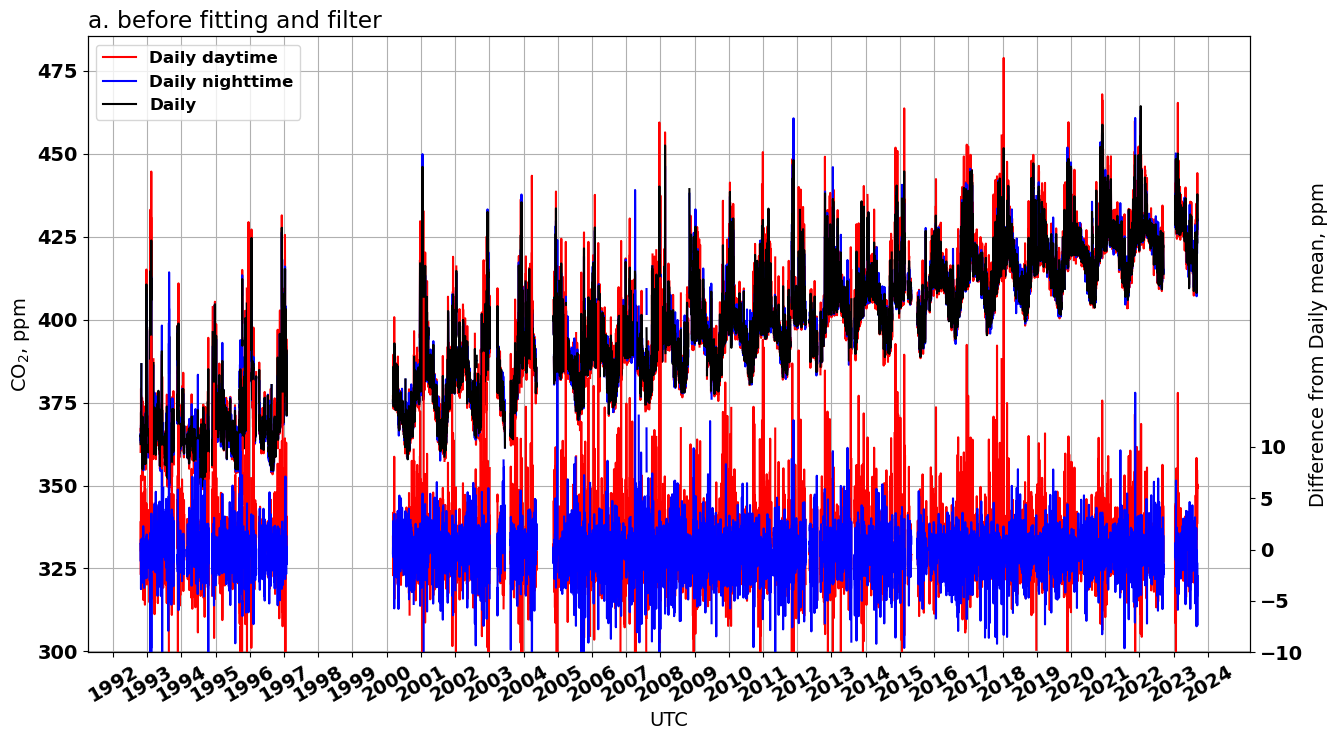

In [13]:
fig,axes = plt.subplots(1,1, sharex=True, figsize = (15,8))
(ax1)=axes
x=df_daily_dtime.decimalyear
ax1.plot(x, df_daily_dtime.co2, color="red", label = "Daily daytime" )
x=df_daily_ntime.decimalyear
ax1.plot(x, df_daily_ntime.co2, color="blue", label = "Daily nighttime" )
x=df_daily.decimalyear
ax1.plot(x, df_daily.co2, color="black", label = "Daily" )

ax1.set_ylim(df_daily.co2.min()-50,)
ax1.set_xticks(np.arange(np.floor(x.min()),np.ceil(x.max())+1))
ax1.set_xlabel("UTC")
ax1.set_ylabel("$\mathregular{CO_2}$, ppm")
ax1.legend()
ax1.grid()
ax1.tick_params(axis='x', labelrotation = 30)
ax1.set_title("a. before fitting and filter", loc = "left");
ax1.legend(fontsize=12)

ax1_sec = ax1.twinx()

y_ddiff = df_daily_dtime.co2-df_daily.co2
y_ndiff = df_daily_ntime.co2-df_daily.co2

ax1_sec.plot(x, y_ddiff, color="red", label = "Daily - Daily daytime")
ax1_sec.plot(x, y_ndiff, color="blue", label = "Daily - Daily nighttime")

ax1_sec.set_ylim(-10,50)
ax1_sec.set_yticks(np.arange(-10,15,5))
ax1_sec.set_ylabel("Difference from Daily mean, ppm");

# 3. Apply NOAA curve fitting

Short introduction of the key function and parameter settings, these functions are available after <code>import ccg_filter</code>:


class **ccg_filter.ccgFilter**(xp, yp , shortterm=80, longterm=667, sampleinterval=0,
numpolyterms=3, numharmonics=4, timezero = -1, gap=0, use_gain_factor=False, debug=False)<br>
**xp** (numpy array) – Time values must be decimal dates<br>
**yp** (numpy array) – Dependent values, here i.e. co2.<br>
**shortterm** (int) – Short term cutoff value in days for smoothing of data.<br>
**longterm** (int) – Long term cutoff value in days for extracting trend from data<br>
**sampleinterval** (int) – Interval in days between samples, calculate equally spaced values at this interval. Default is calculated from xp<br>
**numpoly** (int) – Number of polynomial terms used in function fit - e.g. 3 = quadratic<br>
**numharm** (int) – Number of harmonics used in function fit<br>
**timezero** (float) – Value where x = 0 in the function coefficients. If timezero = -1, it will be reset to the year of the first data point.<br>
**gap** (float) – When determining equally spaced values for the fft, if gap!= 0, then gap is the number of days between samples that should be filled in with values from the function, rather than linear interpolated.<br>
**use_gain_factor** (boolean) – Set to True if you want to include a gain factor to the harmonic amplitude. This means the harmonics part of the function will have a linearly increasing or decreasing amplitude with time.<br>
**debug** (boolean) – If true, print out extra information during calculations.<br>

<font color=red>The curve fitting parameter settings are different</font> for land sites and sea sites (ship measurements), [Click here](https://gml.noaa.gov/ccgg/mbl/map.php) to check the default settings for land and see sites.


## 3.1. Set parameters

In [14]:
# Set key parameters for the ccg_filter
shortterm=80
longterm=667
sampleinterval=1
numpolyterms=4
numharmonics=3

## 3.2. Curve fitting

In [15]:
# daily
txt_time = "daily"
df_daily = df_daily.loc[~np.isnan(df_daily.co2)]
xp = df_daily["decimalyear"]
yp = df_daily["co2"]
filt = ccg_filter.ccgFilter(xp, yp, shortterm, longterm, sampleinterval, numpolyterms, numharmonics)
df_daily_filt = get_filt_df(filt, df_daily)
df_daily_filt.to_csv(OUT_PATH + file[0:7] + "_fit_filter_"+txt_time+".csv", header=True,index=False, na_rep= "NaN")

In [16]:
# daily daytime
txt_time = "daytime"
df_daily_dtime = df_daily_dtime.loc[~np.isnan(df_daily_dtime.co2)]
xp = df_daily_dtime["decimalyear"]
yp = df_daily_dtime["co2"]
filt_dtime = ccg_filter.ccgFilter(xp, yp, shortterm, longterm, sampleinterval, numpolyterms, numharmonics)
df_dtime_filt = get_filt_df(filt_dtime, df_daily_dtime)
df_dtime_filt.to_csv(OUT_PATH + file[0:7] + "_fit_filter_"+txt_time+".csv", header=True,index=False, na_rep= "NaN")

In [17]:
# daily nighttime
txt_time = "nighttime"
df_daily_ntime = df_daily_ntime.loc[~np.isnan(df_daily_ntime.co2)]
xp_ntime = df_daily_ntime["decimalyear"]
yp_ntime = df_daily_ntime["co2"]
filt_ntime = ccg_filter.ccgFilter(xp_ntime, yp_ntime, shortterm, longterm, sampleinterval, numpolyterms, numharmonics)
df_ntime_filt = get_filt_df(filt_ntime, df_daily_ntime)
df_ntime_filt.to_csv(OUT_PATH + file[0:7] + "_fit_filter_"+txt_time+".csv", header=True,index=False, na_rep= "NaN")

## 3.3. Visualize curve fitting and growth rate

### 3.3.1. Daily data

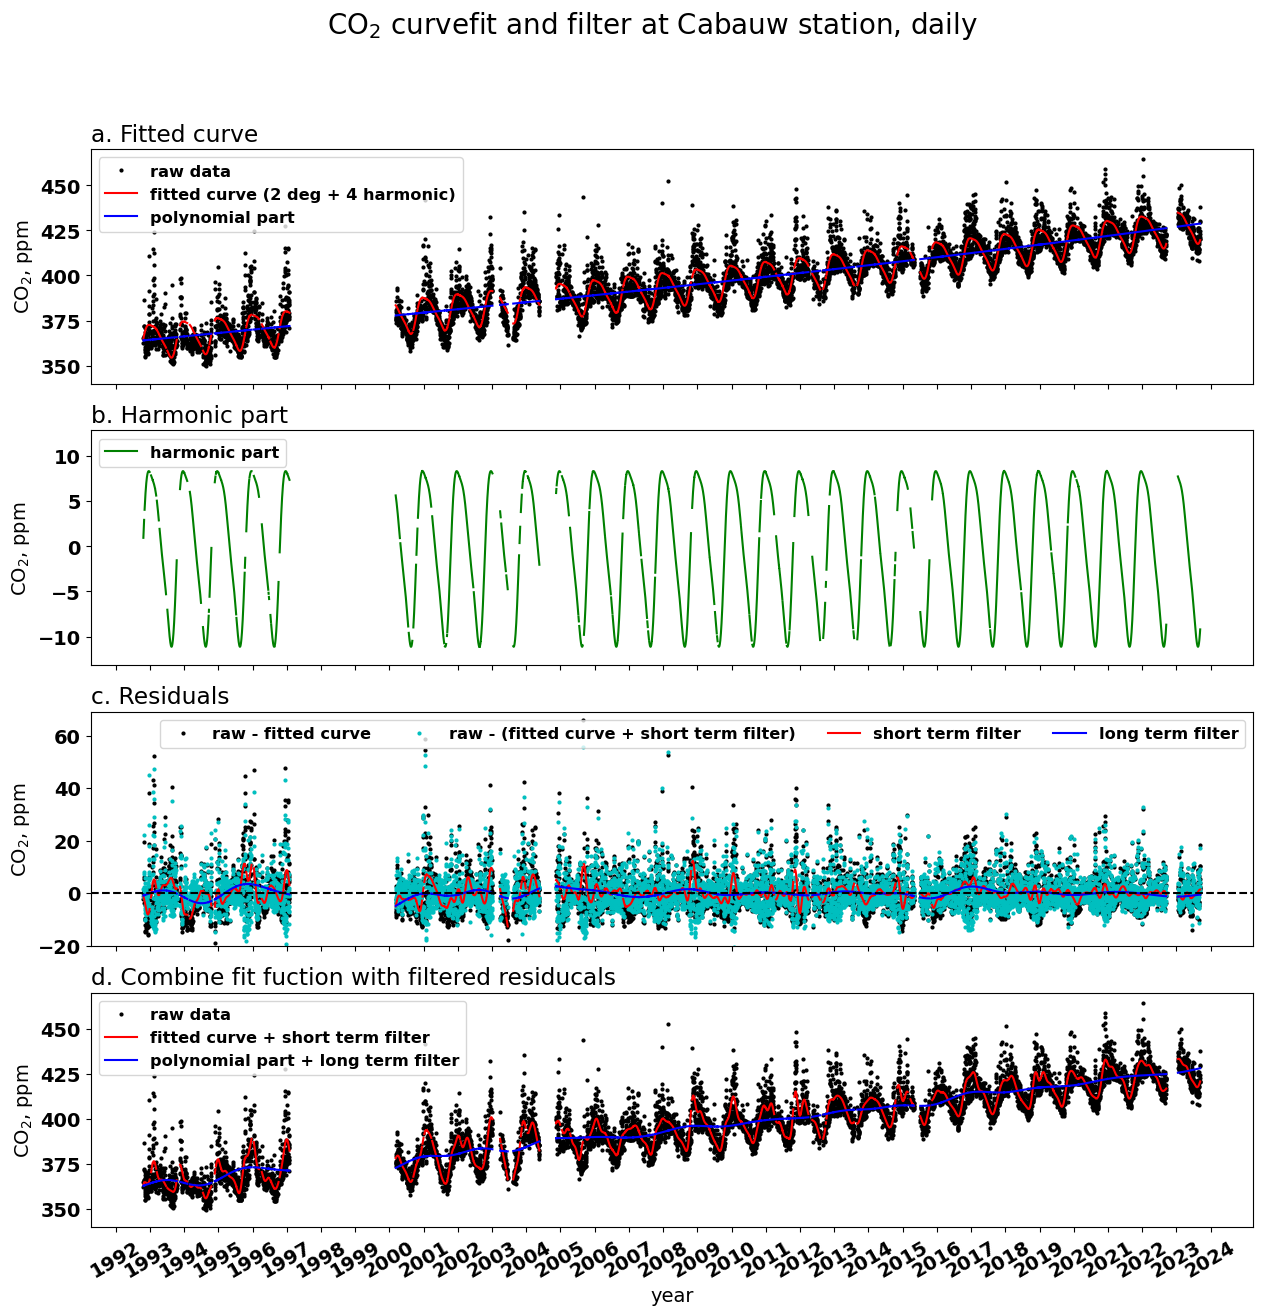

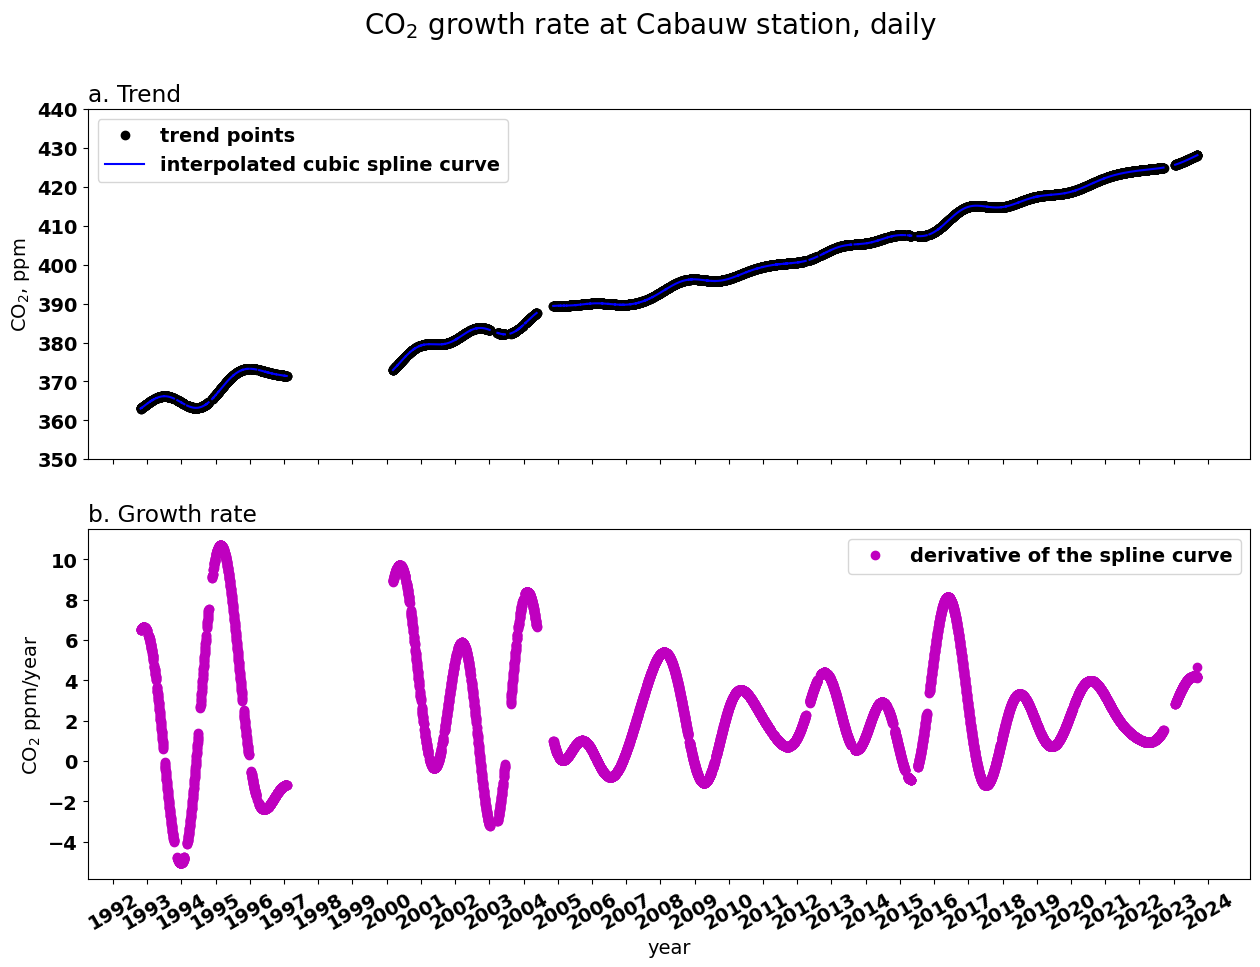

In [18]:
station = dat.site_name
txt_time = "daily"
# for fit plot
xp = df_daily["decimalyear"]
yp = df_daily["co2"]
x0 = df_daily_filt.decimalyear
y1 = filt.getFunctionValue(x0)
y2 = filt.getPolyValue(x0)
y3 = filt.getSmoothValue(x0)
y4 = filt.getTrendValue(x0)
harmonics = filt.getHarmonicValue(x0)
resid_from_func = df_daily_filt.co2 - y1
resid_smooth = y3 - y1
resid_trend = y4 -y2

# for growth rate plot
trendp = filt.getTrendValue(xp)
tck = sp.interpolate.splrep(x0, y4)
trend_spl = sp.interpolate.splev(x0, tck)
trend_der1 = sp.interpolate.splev(x0, tck, der=1)

# Make the interpolated part invisible in the plot
y1[df_daily_filt.co2.isna()] = np.nan
y2[df_daily_filt.co2.isna()] = np.nan
y3[df_daily_filt.co2.isna()] = np.nan
y4[df_daily_filt.co2.isna()] = np.nan
harmonics[df_daily_filt.co2.isna()] = np.nan
resid_smooth[df_daily_filt.co2.isna()] = np.nan
resid_trend[df_daily_filt.co2.isna()] = np.nan
trend_spl[df_daily_filt.co2.isna()] = np.nan
trend_der1[df_daily_filt.co2.isna()] = np.nan


plot_fit(xp, yp, x0, y1, y2, harmonics, resid_from_func, resid_smooth, resid_trend, station,txt_time = txt_time, ymin=340, ymax=470,ifsaveplot = 1)
plot_growthrate(xp, trendp, x0, trend_spl, trend_der1, station, txt_time = txt_time, ymin=350, ymax=440, ifsaveplot = 1)

### 3.3.2. Daily daytime data

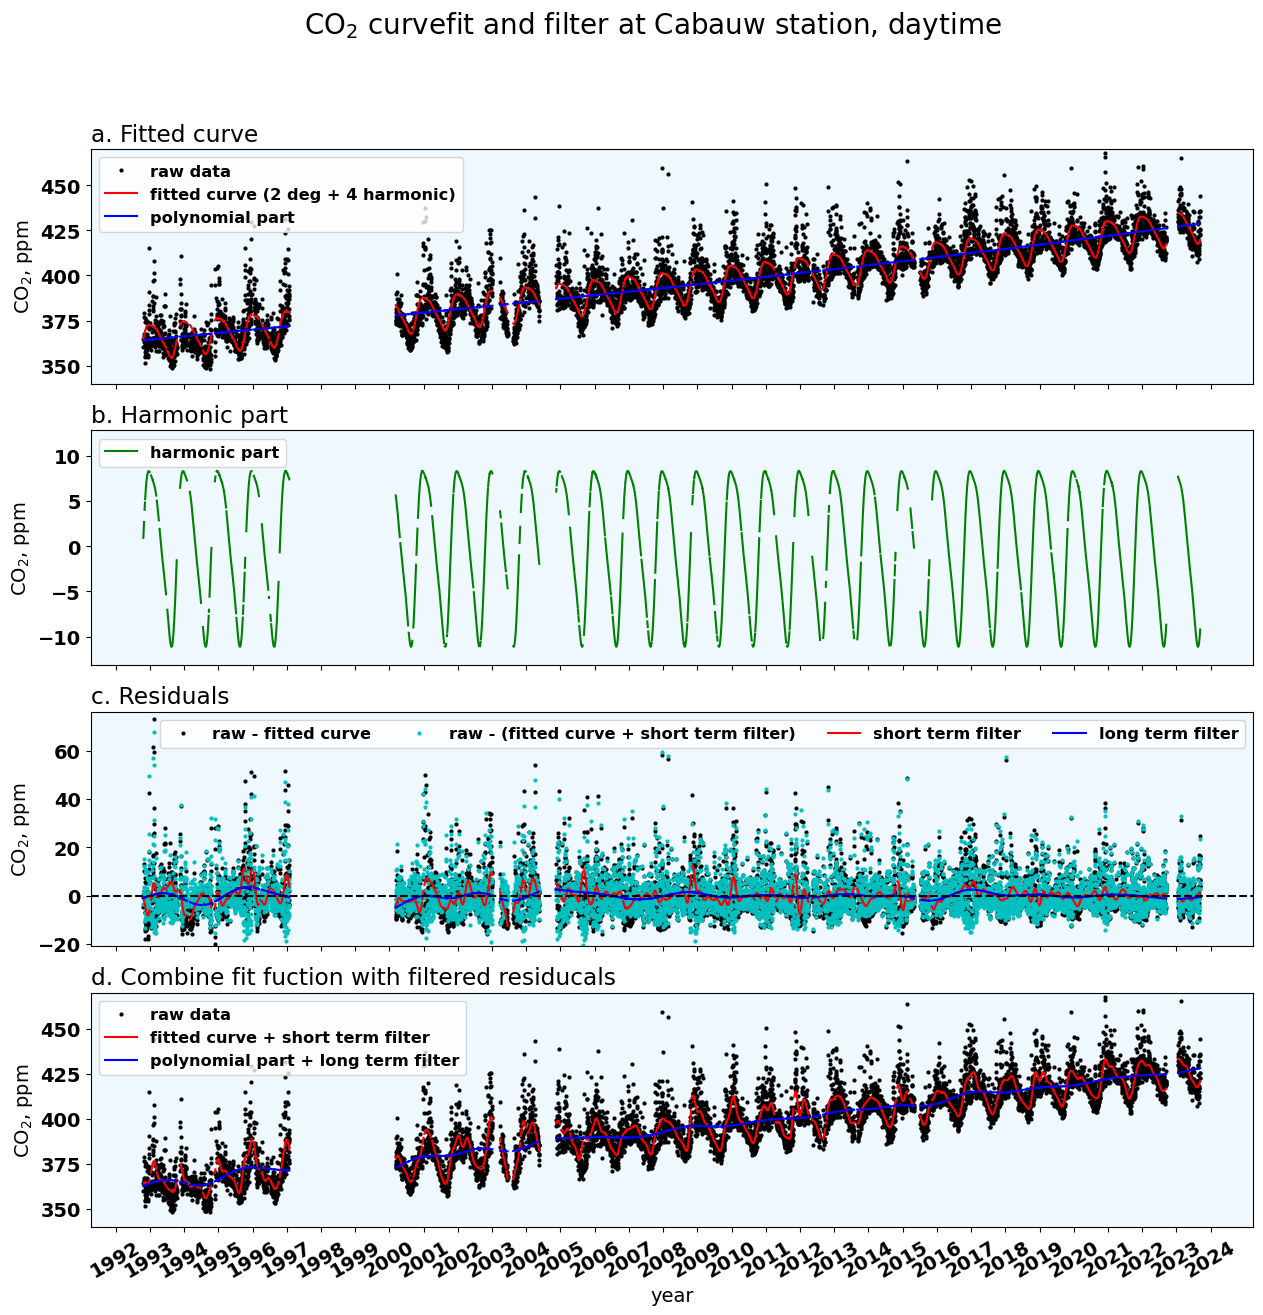

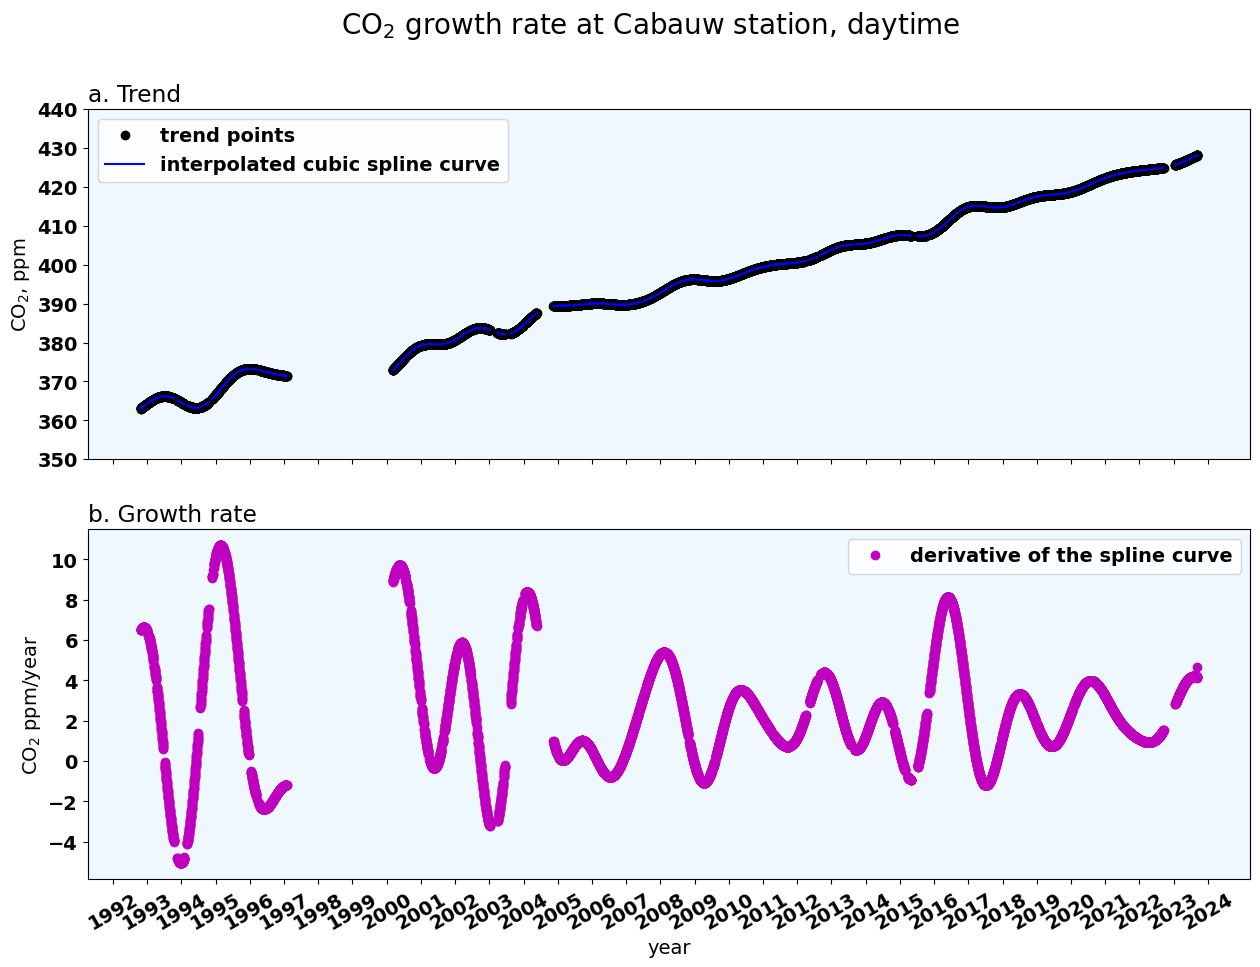

In [19]:
station = dat.site_name
txt_time = "daytime"
# for fit plot
xp = df_daily_dtime["decimalyear"]
yp = df_daily_dtime["co2"]
x0 = df_dtime_filt.decimalyear
y1 = filt.getFunctionValue(x0)
y2 = filt.getPolyValue(x0)
y3 = filt.getSmoothValue(x0)
y4 = filt.getTrendValue(x0)
harmonics = filt.getHarmonicValue(x0)
resid_from_func = df_dtime_filt.co2 - y1
resid_smooth = y3 - y1
resid_trend = y4 -y2

# for growth rate plot
trendp = filt.getTrendValue(xp)
tck = sp.interpolate.splrep(x0, y4)
trend_spl = sp.interpolate.splev(x0, tck)
trend_der1 = sp.interpolate.splev(x0, tck, der=1)

# Make the interpolated part invisible in the plot
y1[df_dtime_filt.co2.isna()] = np.nan
y2[df_dtime_filt.co2.isna()] = np.nan
y3[df_dtime_filt.co2.isna()] = np.nan
y4[df_dtime_filt.co2.isna()] = np.nan
harmonics[df_dtime_filt.co2.isna()] = np.nan
resid_smooth[df_dtime_filt.co2.isna()] = np.nan
resid_trend[df_dtime_filt.co2.isna()] = np.nan
trend_spl[df_dtime_filt.co2.isna()] = np.nan
trend_der1[df_dtime_filt.co2.isna()] = np.nan

plot_fit(xp, yp, x0, y1, y2, harmonics, resid_from_func, resid_smooth, resid_trend, station,txt_time = txt_time, ymin=340, ymax=470,ifsaveplot = 1)
plot_growthrate(xp, trendp, x0, trend_spl, trend_der1, station, txt_time = txt_time,ymin=350, ymax=440, ifsaveplot = 1)

### 3.3.3. Daily nighttime data

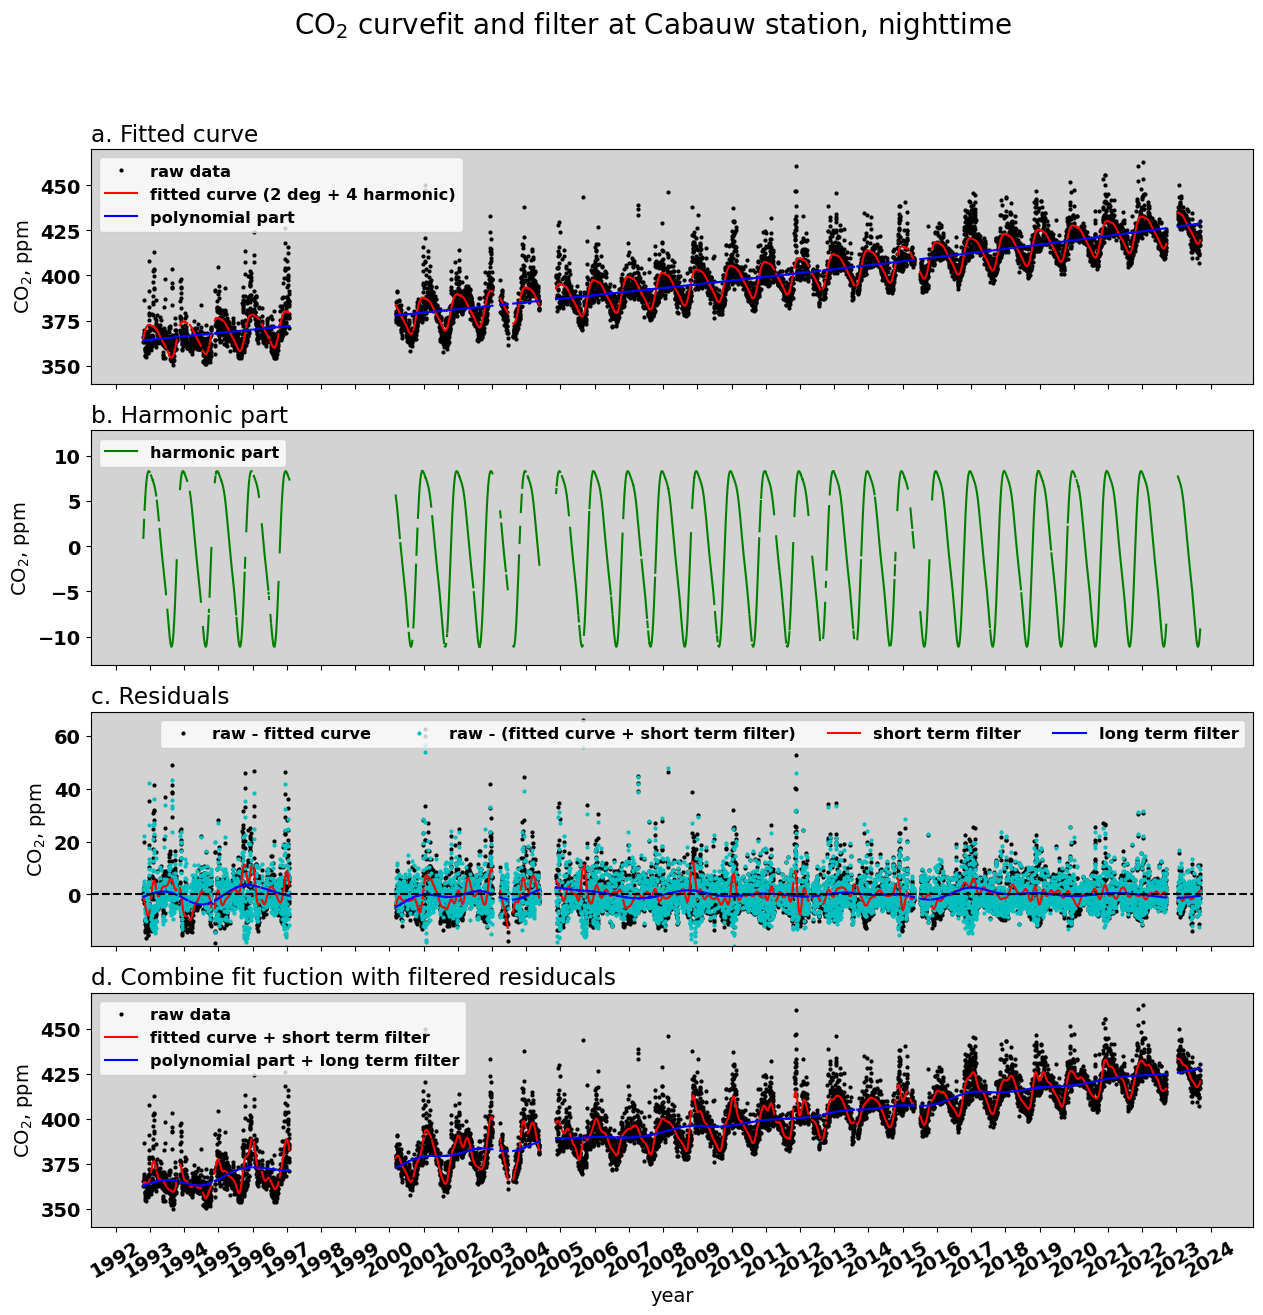

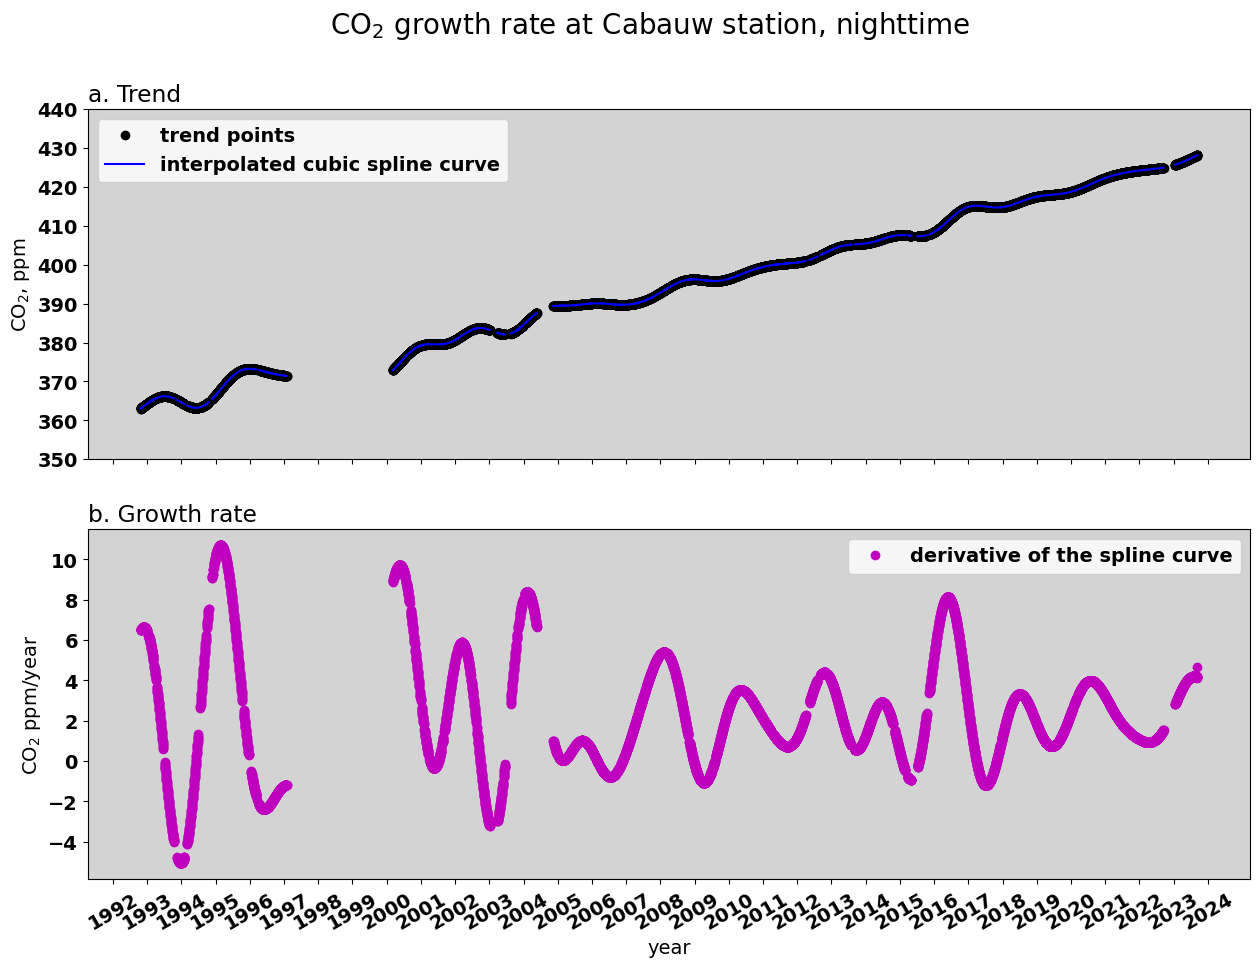

In [20]:
station = dat.site_name
txt_time = "nighttime"
# for fit plot
xp = df_daily_ntime["decimalyear"]
yp = df_daily_ntime["co2"]
x0 = df_ntime_filt.decimalyear
y1 = filt.getFunctionValue(x0)
y2 = filt.getPolyValue(x0)
y3 = filt.getSmoothValue(x0)
y4 = filt.getTrendValue(x0)
harmonics = filt.getHarmonicValue(x0)
resid_from_func = df_ntime_filt.co2 - y1
resid_smooth = y3 - y1
resid_trend = y4 -y2

# for growth rate plot
trendp = filt.getTrendValue(xp)
tck = sp.interpolate.splrep(x0, y4)
trend_spl = sp.interpolate.splev(x0, tck)
trend_der1 = sp.interpolate.splev(x0, tck, der=1)

# Make the interpolated part invisible in the plot
y1[df_ntime_filt.co2.isna()] = np.nan
y2[df_ntime_filt.co2.isna()] = np.nan
y3[df_ntime_filt.co2.isna()] = np.nan
y4[df_ntime_filt.co2.isna()] = np.nan
harmonics[df_ntime_filt.co2.isna()] = np.nan
resid_smooth[df_ntime_filt.co2.isna()] = np.nan
resid_trend[df_ntime_filt.co2.isna()] = np.nan
trend_spl[df_ntime_filt.co2.isna()] = np.nan
trend_der1[df_ntime_filt.co2.isna()] = np.nan

plot_fit(xp, yp, x0, y1, y2, harmonics, resid_from_func, resid_smooth, resid_trend, station,txt_time = txt_time, ymin=340, ymax=470,ifsaveplot = 1)
plot_growthrate(xp, trendp, x0, trend_spl, trend_der1, station, txt_time = txt_time,ymin=350, ymax=440, ifsaveplot = 1)

# 4. Compare fitted and filtered CO$_2$

In [21]:
df_daily_filt = pd.read_csv(OUT_PATH + file[0:7] + "_fit_filter_daily.csv")
df_daily_filt['co2filt'] = df_daily_filt.polypart+df_daily_filt.harmpart+df_daily_filt.resid_smooth
df_daily_filt['trend'] = df_daily_filt.polypart+df_daily_filt.resid_trend
df_daily_filt.co2filt[df_daily_filt.co2.isna()] = np.nan
df_daily_filt.trend[df_daily_filt.co2.isna()] = np.nan
df_daily_filt.growth_rate[df_daily_filt.co2.isna()] = np.nan

df_dtime_filt = pd.read_csv(OUT_PATH + file[0:7] + "_fit_filter_daytime.csv")
df_dtime_filt['co2filt'] = df_dtime_filt.polypart+df_dtime_filt.harmpart+df_dtime_filt.resid_smooth
df_dtime_filt['trend'] = df_dtime_filt.polypart+df_dtime_filt.resid_trend
df_dtime_filt.co2filt[df_dtime_filt.co2.isna()] = np.nan
df_dtime_filt.trend[df_dtime_filt.co2.isna()] = np.nan
df_dtime_filt.growth_rate[df_dtime_filt.co2.isna()] = np.nan

df_ntime_filt = pd.read_csv(OUT_PATH + file[0:7] + "_fit_filter_nighttime.csv")
df_ntime_filt['co2filt'] = df_ntime_filt.polypart+df_ntime_filt.harmpart+df_ntime_filt.resid_smooth
df_ntime_filt['trend'] = df_ntime_filt.polypart+df_ntime_filt.resid_trend
df_ntime_filt.co2filt[df_ntime_filt.co2.isna()] = np.nan
df_ntime_filt.trend[df_ntime_filt.co2.isna()] = np.nan
df_ntime_filt.growth_rate[df_ntime_filt.co2.isna()] = np.nan

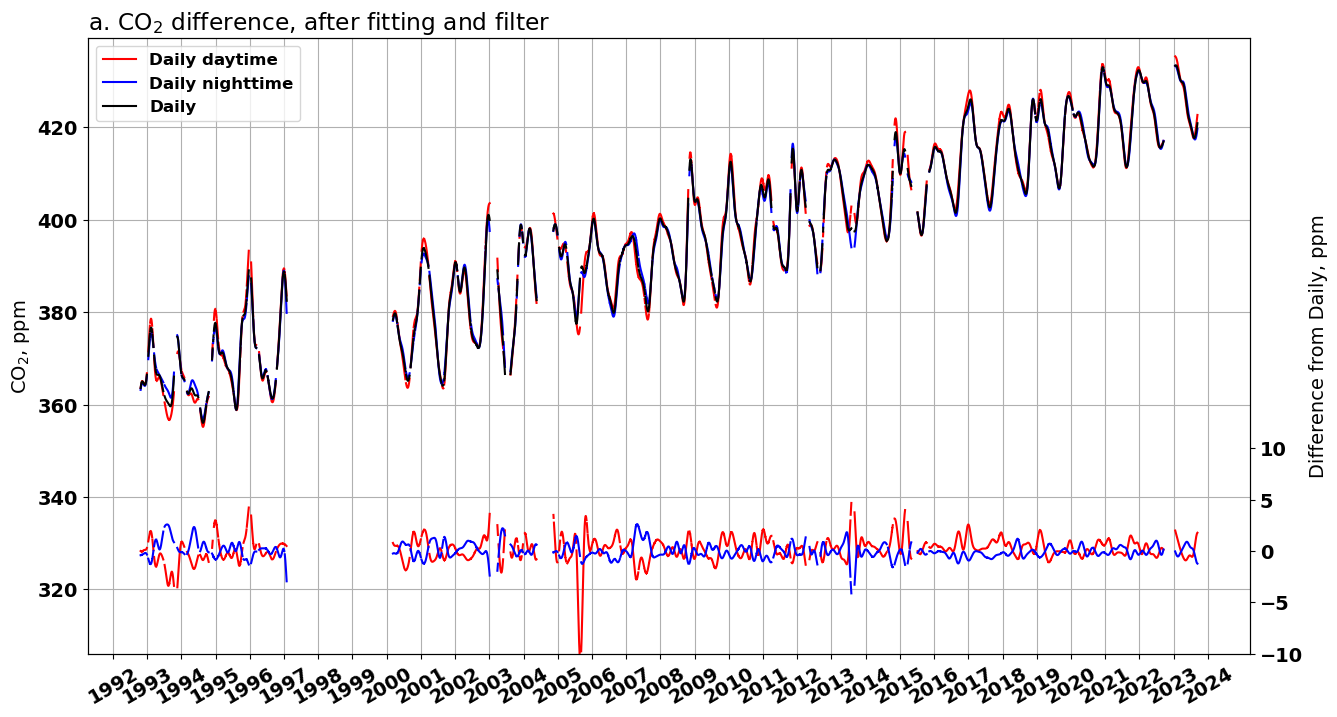

In [22]:
fig,axes = plt.subplots(1,1, sharex=True, figsize = (15,8))
(ax1)=axes
x=df_dtime_filt.decimalyear
ax1.plot(x, df_dtime_filt.co2filt, color="red", label = "Daily daytime" )
x=df_ntime_filt.decimalyear
ax1.plot(x, df_ntime_filt.co2filt, color="blue", label = "Daily nighttime" )
x=df_daily_filt.decimalyear
ax1.plot(x, df_daily_filt.co2filt, color="black", label = "Daily" )

ax1.set_ylim(df_daily_filt.co2filt.min()-50,)
ax1.set_xticks(np.arange(np.floor(x.min()),np.ceil(x.max())+1))
ax1.set_ylabel("$\mathregular{CO_2}$, ppm")
ax1.legend()
ax1.grid()
ax1.tick_params(axis='x', labelrotation = 30)
ax1.set_title("a. $\mathregular{CO_2}$ difference, after fitting and filter", loc = "left");
ax1.legend(fontsize=12)

ax1_sec = ax1.twinx()

y_ddiff = df_dtime_filt.co2filt-df_daily_filt.co2filt
y_ndiff = df_ntime_filt.co2filt-df_daily_filt.co2filt

ax1_sec.plot(x, y_ddiff, color="red", label = "Daily - Daily daytime")
ax1_sec.plot(x, y_ndiff, color="blue", label = "Daily - Daily nighttime")

ax1_sec.set_ylim(-10,50)
ax1_sec.set_yticks(np.arange(-10,15,5))
ax1_sec.set_ylabel("Difference from Daily, ppm");

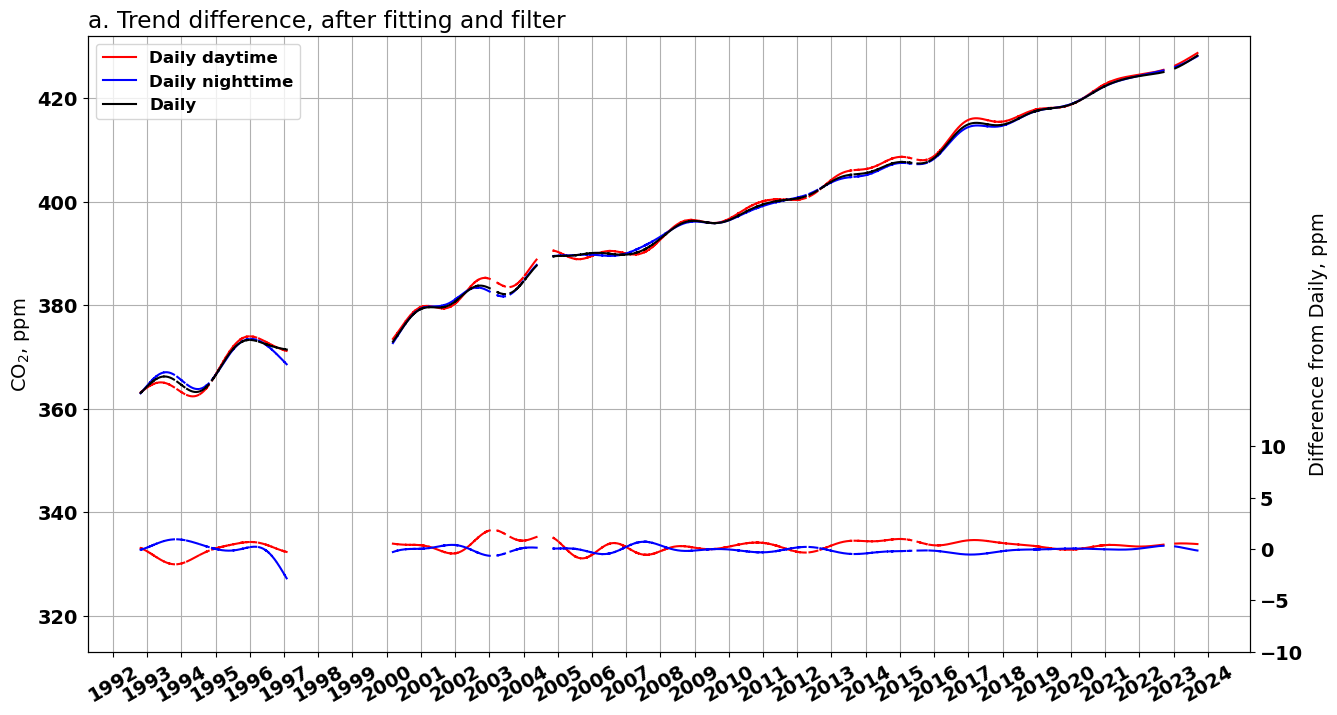

In [23]:
fig,axes = plt.subplots(1,1, sharex=True, figsize = (15,8))
(ax1)=axes
x=df_dtime_filt.decimalyear
ax1.plot(x, df_dtime_filt.trend, color="red", label = "Daily daytime" )
x=df_ntime_filt.decimalyear
ax1.plot(x, df_ntime_filt.trend, color="blue", label = "Daily nighttime" )
x=df_daily_filt.decimalyear
ax1.plot(x, df_daily_filt.trend, color="black", label = "Daily" )

ax1.set_ylim(df_daily_filt.trend.min()-50,)
ax1.set_xticks(np.arange(np.floor(x.min()),np.ceil(x.max())+1))
ax1.set_ylabel("$\mathregular{CO_2}$, ppm")
ax1.legend()
ax1.grid()
ax1.tick_params(axis='x', labelrotation = 30)
ax1.set_title("a. Trend difference, after fitting and filter", loc = "left");
ax1.legend(fontsize=12)

ax1_sec = ax1.twinx()

y_ddiff = df_dtime_filt.trend-df_daily_filt.trend
y_ndiff = df_ntime_filt.trend-df_daily_filt.trend

ax1_sec.plot(x, y_ddiff, color="red", label = "Daily - Daily daytime")
ax1_sec.plot(x, y_ndiff, color="blue", label = "Daily - Daily nighttime")

ax1_sec.set_ylim(-10,50)
ax1_sec.set_yticks(np.arange(-10,15,5))
ax1_sec.set_ylabel("Difference from Daily, ppm");

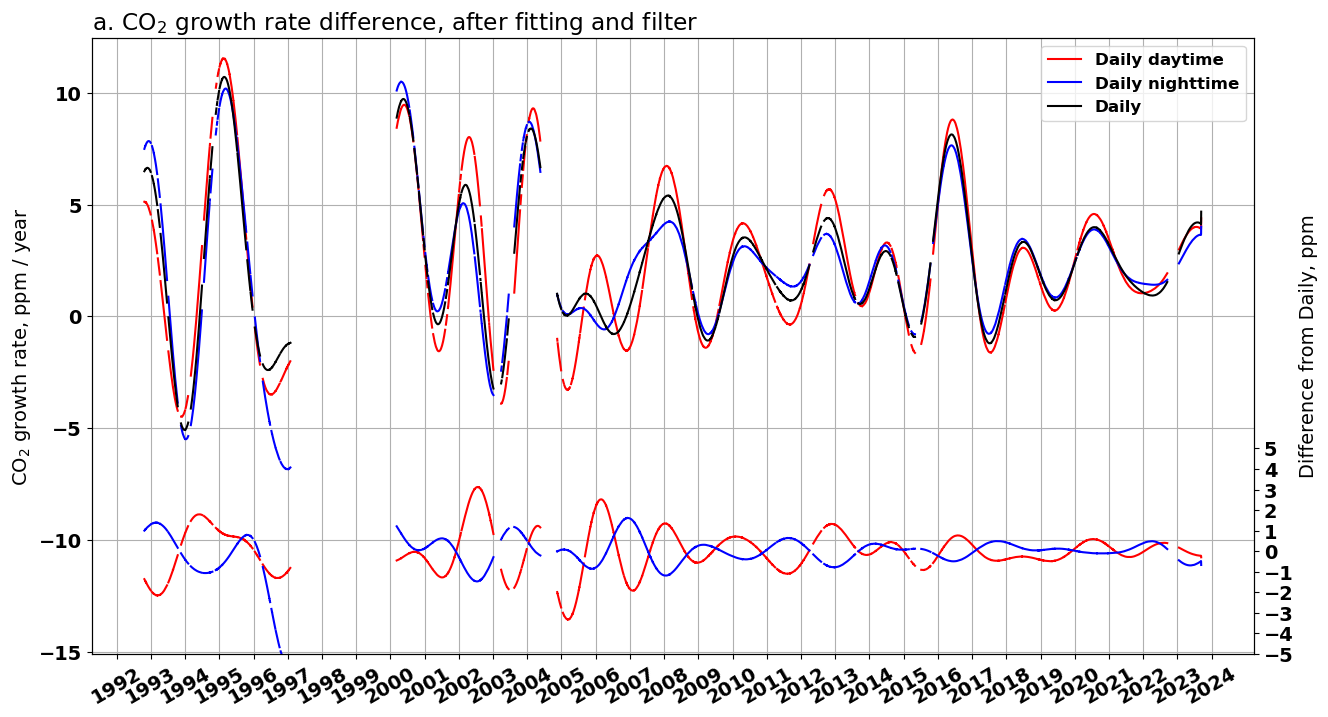

In [24]:
fig,axes = plt.subplots(1,1, sharex=True, figsize = (15,8))
(ax1)=axes
x=df_dtime_filt.decimalyear
ax1.plot(x, df_dtime_filt.growth_rate, color="red", label = "Daily daytime" )
x=df_ntime_filt.decimalyear
ax1.plot(x, df_ntime_filt.growth_rate, color="blue", label = "Daily nighttime" )
x=df_daily_filt.decimalyear
ax1.plot(x, df_daily_filt.growth_rate, color="black", label = "Daily" )

ax1.set_ylim(df_daily_filt.growth_rate.min()-10,)
ax1.set_xticks(np.arange(np.floor(x.min()),np.ceil(x.max())+1))
ax1.set_ylabel("$\mathregular{CO_2}$ growth rate, ppm / year")
ax1.legend()
ax1.grid()
ax1.tick_params(axis='x', labelrotation = 30)
ax1.set_title("a. $\mathregular{CO_2}$ growth rate difference, after fitting and filter", loc = "left");
ax1.legend(fontsize=12)

ax1_sec = ax1.twinx()

y_ddiff = df_dtime_filt.growth_rate-df_daily_filt.growth_rate
y_ndiff = df_ntime_filt.growth_rate-df_daily_filt.growth_rate

ax1_sec.plot(x, y_ddiff, color="red", label = "Daily - Daily daytime")
ax1_sec.plot(x, y_ndiff, color="blue", label = "Daily - Daily nighttime")

ax1_sec.set_ylim(-5,25)
ax1_sec.set_yticks(np.arange(-5,6,1))
ax1_sec.set_ylabel("Difference from Daily, ppm");

<div style="text-align: right">Copyright © 2022-2023 ICOS CP <br>
This work is licensed under a Creative Commons Attribution 4.0 International License (CC BY 4.0).<br>
Any questions about this notebook, please write to zhendong.wu@nateko.lu.se
</div>